In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# Loading camera calibration
cameraCalibration = pickle.load( open('./camera_cal/cam_calib_pickle.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

In [3]:
#Load test images
test_image_files = glob.glob('./test_images/*.jpg')
print("{} Test images loaded".format(len(test_image_files)))

test_images=[]

for f in test_image_files:
    t=cv2.imread(f)
    t=cv2.cvtColor(np.array(t), cv2.COLOR_BGR2RGB)
    test_images.append(t)

8 Test images loaded


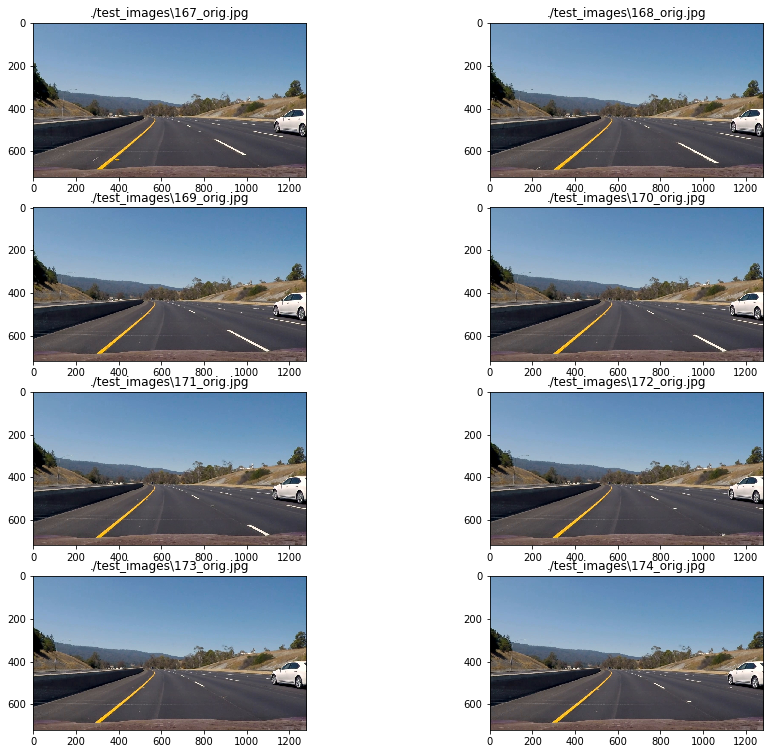

In [4]:
def showImages(images, cols = 4, rows = 5, figsize=(15,10), cmap=None):
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax,indx in zip(axes.flat,indexes):
            image = images[indx]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(test_image_files[indx])
showImages(test_images, 2, 4, (15, 13))

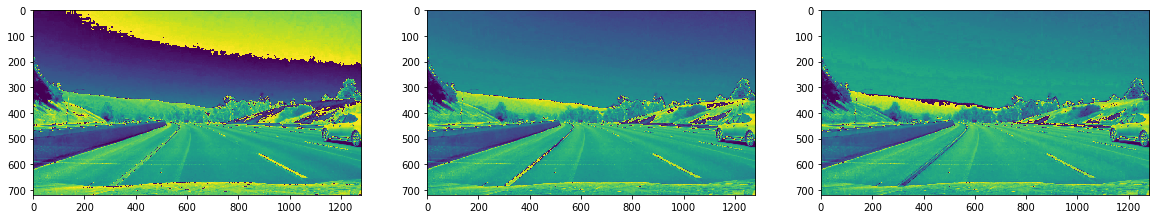

In [6]:
# Undistort and change color space to HLS
def undistandHLS(img, mtx=mtx,dist=dist):
    undist=cv2.undistort(img,mtx,dist,None,mtx)
    return cv2.cvtColor(undist,cv2.COLOR_RGB2HSV)

#hls_test_img=undistandHLS(test_images[1])
hls_test_img=test_images[1]
fig, axes = plt.subplots(ncols=3, figsize=(20,10))
for index, a in enumerate(axes):
    n=1
    if index==2:
        n=0
    a.imshow(hls_test_img[:,:,index]+hls_test_img[:,:,index+n])
    #a.title(str(index+n))
    

In [9]:
# Image processing pipeline
# Based on the images above, the S channel (index 2) returns the lanes more reliably
def sChannelImg(img): 
    #print(np.array(img).shape)
    img=undistandHLS(img)
    return img[:,:,2]

# This applies any threshold to an image
def thresholdimg(img, minthresh,maxthresh):
    img_binary=np.zeros_like(img)
    img_binary[(img>=minthresh) &(img<=maxthresh)]=1
    return img_binary

def sobelimg(img, xory='x', sobel_kernel=3,minthresh=0, maxthresh=255):
    if xory=='x':
        ord1=0
        ord2=1
    else:
        ord1=1
        ord2=0
    
    sobel=cv2.Sobel(img, cv2.CV_64F, ord1, ord2, ksize=sobel_kernel)
    abs_sobel=np.absolute(sobel)
    scaled=np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    return thresholdimg(scaled,minthresh, maxthresh)

def gradients(img,minthresh=0, maxthresh=255):
    img=sChannelImg(img)
    sobelX = sobelimg(img, 'x',3,minthresh,maxthresh)
    sobelY = sobelimg(img, 'y',3,minthresh,maxthresh)
    combined = np.zeros_like(sobelX)
    combined [(sobelX == 1) & (sobelY ==1)] = 1
    return combined


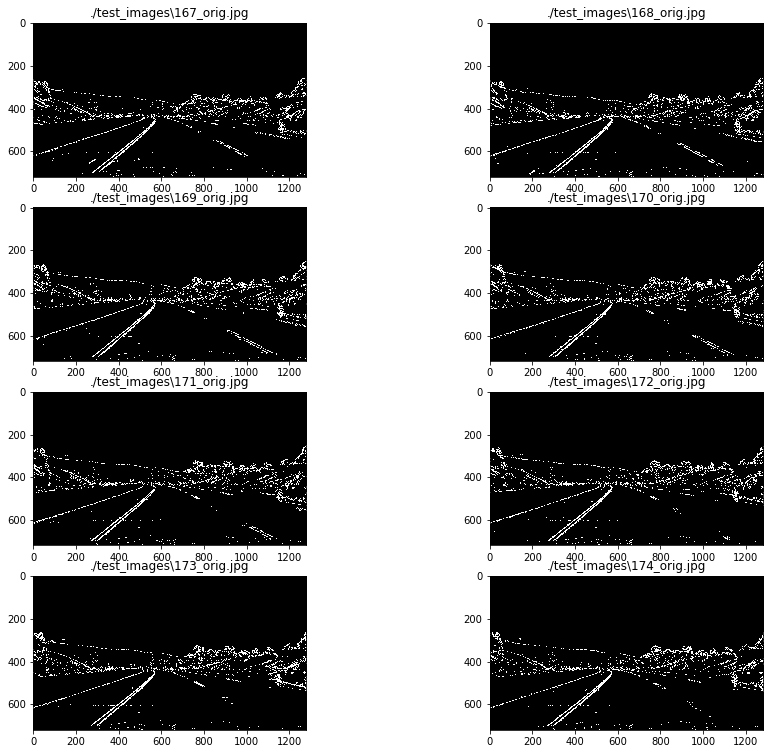

In [10]:
# Test of the image pipeline
result_img=[]
for test_img in test_images:
    img=gradients(test_img,10,160)
    result_img.append(img)

showImages(result_img, 2, 4, (15, 13),cmap='gray')